# Medical Tokenization Demo

This notebook demonstrates:
1. Comparison of generic vs domain-specific tokenization for medical terms
2. Using MedCPT encoder for biomedical text embeddings

In [1]:
# Setup imports
import sys
sys.path.append('..')

from transformers import AutoTokenizer, AutoModel
import torch
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 1. Generic vs Domain Tokenization

Let's see how generic tokenizers fragment medical terminology:

In [2]:
def compare_medical_tokenization():
    """Shows advantage of domain-specific tokenization."""
    # Generic tokenizer
    generic = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Medical terms that generic tokenizers fragment
    medical_terms = [
        "pneumonoultramicroscopicsilicovolcanoconiosis",
        "electroencephalography",
        "thrombocytopenia",
        "gastroesophageal",
        "myocardial infarction",
        "cholecystectomy",
        "diabetes mellitus"
    ]

    print("=== Generic vs Domain Tokenization ===")
    print()
    
    results = []
    for term in medical_terms:
        generic_tokens = generic.tokenize(term)
        results.append({
            'term': term,
            'tokens': generic_tokens,
            'count': len(generic_tokens)
        })
        
        print(f"'{term}':")
        print(f"  Tokens: {generic_tokens}")
        print(f"  Count: {len(generic_tokens)} tokens")
        
        # Calculate efficiency loss
        if len(generic_tokens) > 3:
            print(f"  ⚠️ Excessive fragmentation: {len(generic_tokens)} pieces")
        print()
    
    return results

# Run the comparison
results = compare_medical_tokenization()

=== Generic vs Domain Tokenization ===

'pneumonoultramicroscopicsilicovolcanoconiosis':
  Tokens: ['p', '##ne', '##um', '##ono', '##ult', '##ram', '##ic', '##ros', '##copic', '##sil', '##ico', '##vo', '##lc', '##ano', '##con', '##ios', '##is']
  Count: 17 tokens
  ⚠️ Excessive fragmentation: 17 pieces

'electroencephalography':
  Tokens: ['electro', '##ence', '##pha', '##log', '##raphy']
  Count: 5 tokens
  ⚠️ Excessive fragmentation: 5 pieces

'thrombocytopenia':
  Tokens: ['th', '##rom', '##bo', '##cy', '##top', '##enia']
  Count: 6 tokens
  ⚠️ Excessive fragmentation: 6 pieces

'gastroesophageal':
  Tokens: ['gas', '##tro', '##es', '##op', '##ha', '##ge', '##al']
  Count: 7 tokens
  ⚠️ Excessive fragmentation: 7 pieces

'myocardial infarction':
  Tokens: ['my', '##oca', '##rdial', 'in', '##far', '##ction']
  Count: 6 tokens
  ⚠️ Excessive fragmentation: 6 pieces

'cholecystectomy':
  Tokens: ['cho', '##le', '##cy', '##ste', '##ct', '##omy']
  Count: 6 tokens
  ⚠️ Excessive fragment

## 2. Visualize Tokenization Fragmentation

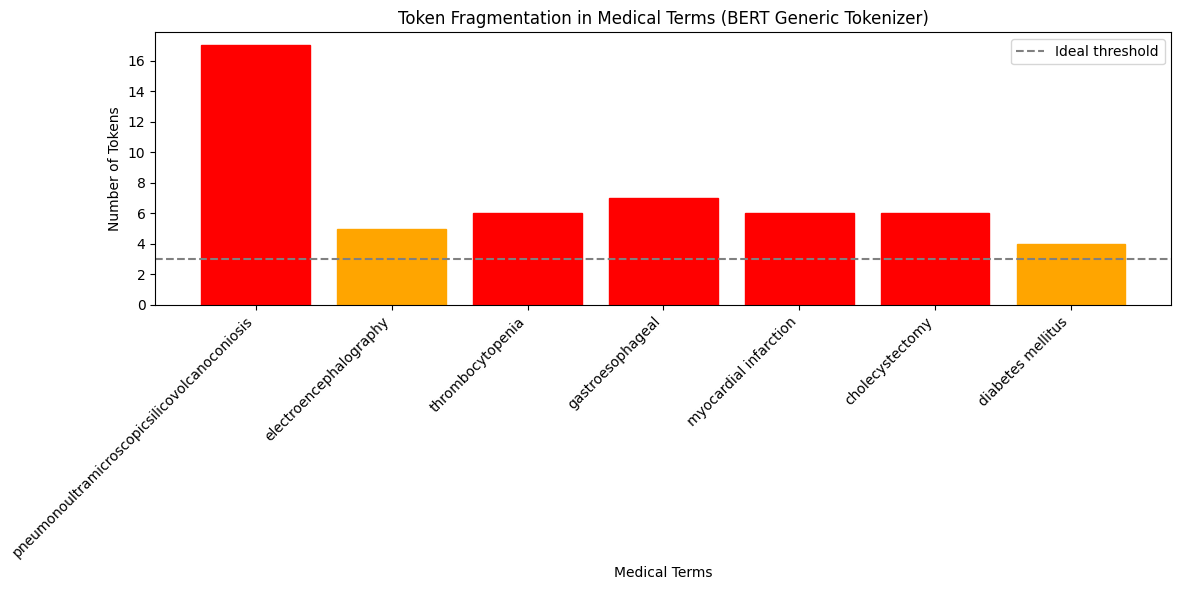

In [3]:
import matplotlib.pyplot as plt

# Extract data for visualization
terms = [r['term'] for r in results]
token_counts = [r['count'] for r in results]

# Create bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(terms)), token_counts, color='skyblue')

# Color bars based on fragmentation level
for i, count in enumerate(token_counts):
    if count > 5:
        bars[i].set_color('red')
    elif count > 3:
        bars[i].set_color('orange')
    else:
        bars[i].set_color('green')

plt.xlabel('Medical Terms')
plt.ylabel('Number of Tokens')
plt.title('Token Fragmentation in Medical Terms (BERT Generic Tokenizer)')
plt.xticks(range(len(terms)), terms, rotation=45, ha='right')
plt.tight_layout()

# Add horizontal line at y=3 to show threshold
plt.axhline(y=3, color='gray', linestyle='--', label='Ideal threshold')
plt.legend()

plt.show()

## 3. MedCPT Encoder for Biomedical Text

Now let's use a specialized medical encoder:

In [4]:
def load_medcpt_encoder():
    """Load MedCPT encoder model and tokenizer."""
    print("Loading MedCPT Article Encoder...")
    try:
        model = AutoModel.from_pretrained("ncbi/MedCPT-Article-Encoder")
        tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Article-Encoder")
        print("✅ MedCPT loaded successfully!")
        return model, tokenizer
    except Exception as e:
        print(f"❌ Error loading MedCPT: {e}")
        print("Note: This requires ~440MB download on first run")
        return None, None

# Load the model
medcpt_model, medcpt_tokenizer = load_medcpt_encoder()

Loading MedCPT Article Encoder...
✅ MedCPT loaded successfully!


## 4. Encode Medical Articles

In [5]:
if medcpt_model and medcpt_tokenizer:
    # Example medical articles
    articles = [
        [
            "Diagnosis and Management of Central Diabetes Insipidus in Adults",
            "Central diabetes insipidus (CDI) is a clinical syndrome which results from loss or impaired function of vasopressinergic neurons in the hypothalamus/posterior pituitary, resulting in impaired synthesis and/or secretion of arginine vasopressin (AVP).",
        ],
        [
            "Adipsic diabetes insipidus",
            "Adipsic diabetes insipidus (ADI) is a rare but devastating disorder of water balance with significant associated morbidity and mortality. Most patients develop the disease as a result of hypothalamic destruction from a variety of underlying etiologies.",
        ],
        [
            "Nephrogenic diabetes insipidus: a comprehensive overview",
            "Nephrogenic diabetes insipidus (NDI) is characterized by the inability to concentrate urine that results in polyuria and polydipsia, despite having normal or elevated plasma concentrations of arginine vasopressin (AVP).",
        ],
    ]
    
    # Format articles
    formatted_articles = [f"{title}. {abstract}" for title, abstract in articles]
    
    print("Encoding medical articles...")
    with torch.no_grad():
        # Tokenize
        encoded = medcpt_tokenizer(
            formatted_articles, 
            truncation=True, 
            padding=True, 
            return_tensors='pt', 
            max_length=512,
        )
        
        # Get embeddings
        embeds = medcpt_model(**encoded).last_hidden_state[:, 0, :]
        
        print(f"\n✅ Generated embeddings shape: {embeds.shape}")
        print(f"Each article is represented as a {embeds.shape[1]}-dimensional vector")

Encoding medical articles...

✅ Generated embeddings shape: torch.Size([3, 768])
Each article is represented as a 768-dimensional vector


## 5. Compare MedCPT vs Generic BERT Tokenization

In [6]:
if medcpt_tokenizer:
    # Medical terms to compare
    medical_terms = [
        "diabetes insipidus",
        "vasopressinergic neurons",
        "hypothalamic destruction",
        "polyuria and polydipsia",
        "myocardial infarction",
        "electroencephalography"
    ]
    
    generic = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    print("=== MedCPT vs Generic BERT Tokenization ===")
    print()
    
    comparison_data = []
    
    for term in medical_terms:
        medcpt_tokens = medcpt_tokenizer.tokenize(term)
        generic_tokens = generic.tokenize(term)
        
        comparison_data.append({
            'term': term,
            'medcpt_count': len(medcpt_tokens),
            'generic_count': len(generic_tokens),
            'difference': len(generic_tokens) - len(medcpt_tokens)
        })
        
        print(f"'{term}':")
        print(f"  MedCPT: {medcpt_tokens} ({len(medcpt_tokens)} tokens)")
        print(f"  Generic: {generic_tokens} ({len(generic_tokens)} tokens)")
        
        if len(generic_tokens) > len(medcpt_tokens):
            print(f"  ✅ MedCPT is {len(generic_tokens) - len(medcpt_tokens)} tokens more efficient")
        print()

=== MedCPT vs Generic BERT Tokenization ===

'diabetes insipidus':
  MedCPT: ['diabetes', 'ins', '##ip', '##idus'] (4 tokens)
  Generic: ['diabetes', 'ins', '##ip', '##id', '##us'] (5 tokens)
  ✅ MedCPT is 1 tokens more efficient

'vasopressinergic neurons':
  MedCPT: ['vasopressin', '##ergic', 'neurons'] (3 tokens)
  Generic: ['va', '##sop', '##ress', '##iner', '##gic', 'neurons'] (6 tokens)
  ✅ MedCPT is 3 tokens more efficient

'hypothalamic destruction':
  MedCPT: ['hypothalamic', 'destruction'] (2 tokens)
  Generic: ['h', '##yp', '##oth', '##ala', '##mic', 'destruction'] (6 tokens)
  ✅ MedCPT is 4 tokens more efficient

'polyuria and polydipsia':
  MedCPT: ['poly', '##uria', 'and', 'polyd', '##ips', '##ia'] (6 tokens)
  Generic: ['poly', '##uria', 'and', 'poly', '##di', '##ps', '##ia'] (7 tokens)
  ✅ MedCPT is 1 tokens more efficient

'myocardial infarction':
  MedCPT: ['myocardial', 'infarction'] (2 tokens)
  Generic: ['my', '##oca', '##rdial', 'in', '##far', '##ction'] (6 tokens

## 6. Visualize Tokenization Efficiency

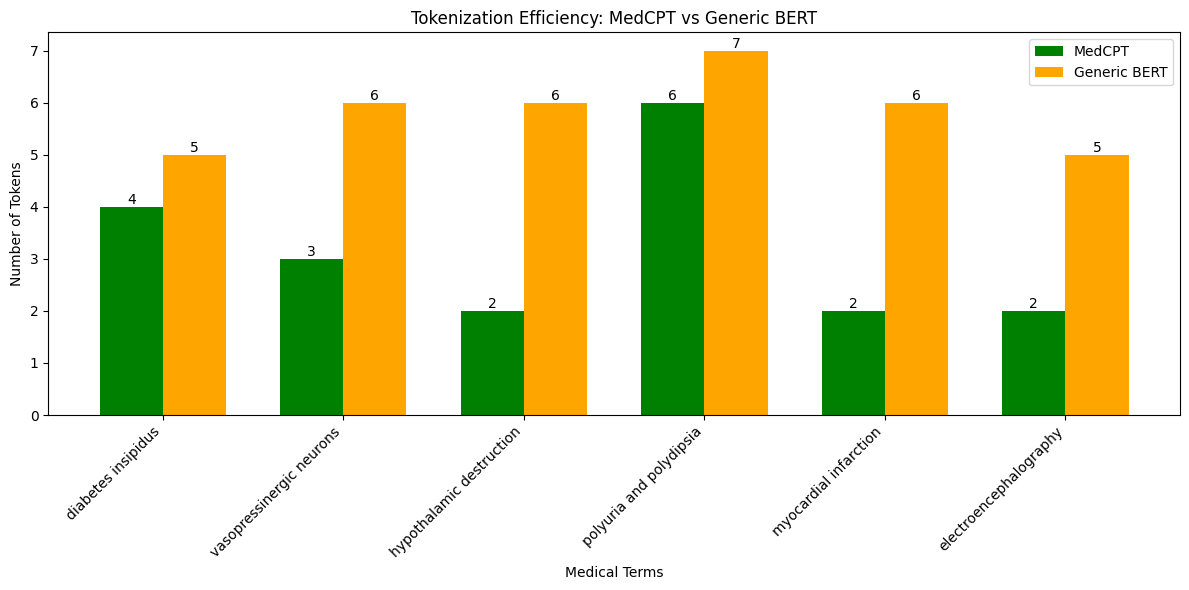


📊 Summary Statistics:
Average tokens (MedCPT): 3.2
Average tokens (Generic): 5.8
Efficiency gain: 45.7%


In [7]:
if comparison_data:
    import numpy as np
    
    # Prepare data
    terms = [d['term'] for d in comparison_data]
    medcpt_counts = [d['medcpt_count'] for d in comparison_data]
    generic_counts = [d['generic_count'] for d in comparison_data]
    
    # Create grouped bar chart
    x = np.arange(len(terms))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, medcpt_counts, width, label='MedCPT', color='green')
    bars2 = ax.bar(x + width/2, generic_counts, width, label='Generic BERT', color='orange')
    
    ax.set_xlabel('Medical Terms')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Tokenization Efficiency: MedCPT vs Generic BERT')
    ax.set_xticks(x)
    ax.set_xticklabels(terms, rotation=45, ha='right')
    ax.legend()
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate average efficiency
    avg_medcpt = np.mean(medcpt_counts)
    avg_generic = np.mean(generic_counts)
    efficiency_gain = ((avg_generic - avg_medcpt) / avg_generic) * 100
    
    print(f"\n📊 Summary Statistics:")
    print(f"Average tokens (MedCPT): {avg_medcpt:.1f}")
    print(f"Average tokens (Generic): {avg_generic:.1f}")
    print(f"Efficiency gain: {efficiency_gain:.1f}%")

## Key Takeaways

1. **Generic tokenizers fragment medical terms** - Leading to inefficient representations
2. **Domain-specific tokenizers preserve terminology** - Better for medical NLP tasks
3. **MedCPT provides specialized embeddings** - Optimized for biomedical text search
4. **Efficiency matters** - Fewer tokens = faster processing and lower costs

### When to Use Each:
- **Generic BERT**: General-purpose text, mixed domains
- **MedCPT**: Medical literature, clinical notes, biomedical search
- **Custom Medical Tokenizers**: When you need maximum control over vocabulary